In [1]:
"""
This notebook trains a diffusion model on an input dataset of images. It assumes that the input data
can be accessed at path IMG_PATH, and trains a diffusion model for that digit class. It also
outputs a set of generated images.

It also contains code for hyperparameter optimization using random search.

This code was heavily adapted from the following tutorial
https://tree.rocks/make-diffusion-model-from-scratch-easy-way-to-implement-quick-diffusion-model-e60d18fd0f2e
"""
pass

# Setup

## Import Required Packages

## Define hyperparameters and configuration variables for the model

In [2]:
# For data operations
import numpy as np

def noise_schedule(timesteps):
  """
  Defines the noise schedule used by the CLASSICAL diffusion model.
  In this work, we use a linear noise schedule.

  Inputs:
    timesteps, an integer representing the number of timesteps for the classical model.

  Returns:
    The noise schedule to be used by the diffusion model; it should
    follow the interface of an array of floats.
  """
  return 1 - np.linspace(0, 1.0, timesteps + 1)

In [3]:
# For diffusion model training
import torch
import random

IMG_SIZE = 32     # input image size; MNIST is 28 by 28, but we pad the image to reshape it
BATCH_SIZE = 10  # for training batch size
timesteps = 9 - 1    # how many steps to turn a noisy image into clear
DIGIT = 0 # The MNIST digit class to train the diffusion model on
# The path where the training images are stored
IMG_PATH = "/content/drive/MyDrive/COMP693_Images/data_img" + str(DIGIT)
# The path to store the results of the model training (generated images and model weights)
DEST_DIR_PATH = "/content/drive/MyDrive/COMP693_diffusion"
LEARNING_RATE = 0.0008 # Step size for optimizer in model
NUM_EPOCHS = 100 # Number of times to train on full dataset
TRAINING_ITERS = 20 # Number of times to train NUM_EPOCHS times, with LEARNING_RATE *= 0.9 for each training iteration
SEED = 42 # Seed for RNG's
CLASSICAL = False # Whether or not we want to train the classical counterpart of this diffusion model
verbose = False # Controls the verbosity when training the model
NUM_QUBITS = 127 # The number of qubits on the target quantum machine

if CLASSICAL:
  # Define a linear space for timesteps used for noising the image classically
  time_bar = noise_schedule(timesteps)
  print(f'time_bar: {time_bar}')

# Use the GPU on this device
device = torch.device('cuda')

# Use the same seed
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

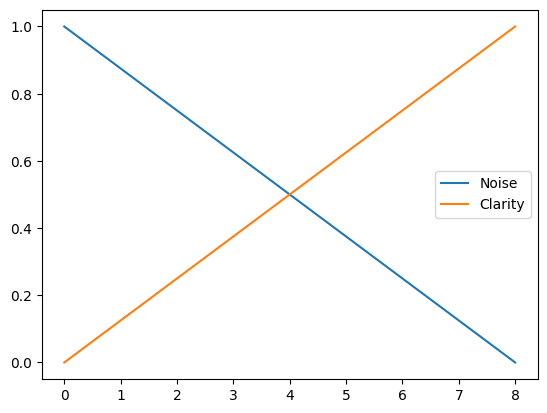

In [4]:
# For plotting
import matplotlib.pyplot as plt

# Plot a general trend of the expected CLASSICAL clarity versus noise of the images
noise_schedule_time = noise_schedule(timesteps)
plt.plot(noise_schedule_time, label='Noise')
plt.plot(1 - noise_schedule_time, label='Clarity')
plt.legend()

# Process Input Images

Convert grayscale images to RGB, as well as pad them with two pixels on each side to adapt to the diffusion model code, as the diffusion model code works for 32 by 32 images, and the training data is 28 by 28 images.

In [5]:
import math
# For processing training data
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

def get_mnist_components(digit, load_training_data, num_qubits, verbose=False):
  """
  Obtains the PCA object and the minimum/maximum values of the features for
  the specified digit class. Uses the training data specified from load_training_data.

  Inputs:
    digit, an integer from 0 through 9 representing the digit class to obtain the PCA features and
    maximum/minimum feature values for
    load_training_data, a function that returns the training data in the form
      (x_train, y_train), (x_test, y_test)
    num_qubits, an integer representing the number of qubits on the target quantum machine
    to perform PCA to
    verbose, a boolean indicating whether debugging output should be printed

  Outputs:
    a tuple containing four objects:
      pca, an sklearn.PCA object for performing PCA on the training data
      max_feature_vals, a numpy array of length equal to the number of features, where
      the value at position i is the maximum value of feature i across the training data
      min_feature_vals, a numpy array of length equal to the number of features, where
      the value at position i is the minimum value of feature i across the training data
      num_feat, an integer representing the number of features
  """
  # Obtain the training data
  (x_train, y_train), (x_test, y_test) = load_training_data()

  if verbose:
    print("loaded mnist data")

  # Normalize the training data
  x_train_flat = x_train.reshape(-1, 28*28) / 255.0
  x_test_flat = x_test.reshape(-1, 28*28) / 255.0

  # Only take digits corresponding to the specified digit
  x_train_category = x_train_flat[y_train == digit]
  x_test_category = x_test_flat[y_test == digit]

  # In our experiments, for digits 0 and 1, we ran them with a number of features sufficient for 95% variance,
  # but for all other digits, we used the number of features equal to the number of qubits on the quantum machine.
  if digit < 2:
    pca = PCA(n_components=.95)
  else:
    pca = PCA(n_components=num_qubits)

  # Obtain the PCA-transformed data
  x_train_pca = pca.fit_transform(x_train_category)
  num_feat = x_train_pca.shape[1]

  # Scale the features to be between 0 and pi
  scaler = MinMaxScaler(feature_range=(0, math.pi))
  scaler.fit(x_train_pca)
  x_train_pca_scaled = scaler.transform(x_train_pca)

  # Find the minimum and maximum values of the original data, for rescaling again
  min_feature_vals = np.min(x_train_pca, axis=0).tolist()
  max_feature_vals = np.max(x_train_pca, axis=0).tolist()

  return pca, max_feature_vals, min_feature_vals, num_feat


def rescale_image(image, pca, max_feature_vals, min_feature_vals, num_feat, verbose=False):
  """
  Rescales an image which assumed that P(q_i = |1>) = θ_i, to correct it
  according to the relationship P(q_i = |0>) = cos^2(θ_i / 2).

  Inputs:
    image, a 28 by 28 numpy array representing the image to correct.
    pca, an sklearn.PCA object for performing PCA on the training data
    max_feature_vals, a numpy array of length equal to the number of features, where
    the value at position i is the maximum value of feature i across the training data
    min_feature_vals, a numpy array of length equal to the number of features, where
    the value at position i is the minimum value of feature i across the training data
    num_feat, an integer representing the number of features
    verbose, a boolean indicating whether debugging output should be printed

  Outputs:
    reshaped_image, a 28 by 28 numpy array representing the corrected image.
  """
  # Obtain the PCA representation of the image.
  flattened_img = image.reshape(-1, 28 * 28)
  orig_pca_states = pca.transform(flattened_img)[0]
  if verbose:
    print(f'orig_pca_states: {orig_pca_states}')
  # Reconstruct the original expected values for the image.
  orig_expected_vals = []
  for i in range(len(orig_pca_states)):
    orig_exp_val = (orig_pca_states[i] - min_feature_vals[i]) / (max_feature_vals[i] - min_feature_vals[i])
    orig_expected_vals.append(orig_exp_val)
  if verbose:
    print(f'orig_expected_vals: {orig_expected_vals}')

  # Add the correct angle values corresponding to the image.
  angle_vals = []
  for prob_1_val in orig_expected_vals:
    prob_0_val = 1 - prob_1_val
    if verbose:
      print(f'prob_1_val: {prob_1_val}')
      print(f'prob_0_val: {prob_0_val}')
    # Unfortunately, we have cases where prob_0_val is < 0 or > 1 due to numerical imprecisions in PCA
    # and the fact that quantum measurements are fundamentally samples. However, we make the assumption
    # that the P(q_i = |0>) will not be significantly larger than 1 nor smaller than 0, and floor them accordingly.
    if prob_0_val > 1:
      if verbose:
        print(f'prob_0_val is too large')
      prob_0_val = 1
    elif prob_0_val < 0:
      if verbose:
        print(f'prob_0_val is too small')
      prob_0_val = 0
    angle_vals.append(2 * math.acos(math.sqrt(prob_0_val)))

  # Scale the expected values to the range of the original PCA features
  pca_states = []
  for i in range(0, num_feat):
      normalized_angle = angle_vals[i] / math.pi
      pca_states.append(normalized_angle * (max_feature_vals[i] - min_feature_vals[i]) + min_feature_vals[i])

  if verbose:
    print(f'pca_states: {pca_states}')

  # Reconstruct the input image
  data_reconstructed = pca.inverse_transform(pca_states)

  reshaped_image = data_reconstructed.reshape(28, 28)

  return reshaped_image

In [6]:
def convert_rgb_to_greyscale(input_grayscale_image, verbose=False):
  """
  Converts a grayscale image into an RGB image with three channels.

  Inputs:
    input_grayscale_image, a two dimensional numpy array representing a grayscale image

  Returns:
    a three dimensional PyTorch tensor, where the first dimension contains the channels, and
    the remaining two encode the image. The three channels all contain the same value.
  """
  if verbose:
    print(f'input_grayscale_img.shape: {input_grayscale_image.shape}')
  # Create a tensor where the values in the input image are repeated three times.
  tensor_img = torch.from_numpy(input_grayscale_image)
  tensor_img = tensor_img.repeat(3, 1, 1)
  if verbose:
    print(f'tensor_img.shape: {tensor_img.shape}')
    print(f'tensor_img: {tensor_img}')
    # print(f'created tensor.shape: {torch.from_numpy(np.array([[[s, s, s] for s in r] for r in input_grayscale_image], dtype="float")).shape}')
  return tensor_img

In [7]:
def standardize_image(input_image, verbose=False):
  """
  Standardize the pixel values to be between 0 and 1, and also pad the image
  with two black pixels on each edge.

  Inputs:
    input_image, a two dimensional numpy array (assumed to be 28 by 28 pixels)
    representing an image
    verbose, a boolean indicating whether debugging output should be printed

  Returns:
    a new two dimensional numpy array padded with two black pixels on each edge,
    with each input pixel value standardized.
  """
  # Flatten the input image and extract the maximum and minimum feature values.
  # there's no need to flatten
  flattened_image = input_image.reshape(-1, 28 * 28)
  max_feature_val = np.amax(flattened_image)
  min_feature_val = np.amin(flattened_image)
  if verbose:
    # print(f'input_image: {input_image}')
    print(f'standardize_image: max_feature_val: {max_feature_val}')
    print(f'standardize_image: min_feature_val: {min_feature_val}')
  # Standardize each pixel value, and produce a resulting 2D numpy array.
  standardized_image = []
  for pixel_val in flattened_image:
    standardized_pixel_val = (pixel_val - min_feature_val) / (max_feature_val - min_feature_val)
    standardized_image.append(standardized_pixel_val)
  standardized_image_reshaped = np.array(standardized_image).reshape(28, 28)
  flattened_image = standardized_image_reshaped

  # Pad the standardized image with two black pixels on each edge.
  flattened_image = np.pad(flattened_image, ((2, 2), (2, 2)), 'constant')
  if verbose:
    print(f'flattened_image.shape: {flattened_image.shape}')
    print(f'flattened_image: {flattened_image}')
  return flattened_image

In [8]:
# Mount Google drive at a specified filepath, for file operations.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
def get_base_img_idxs(data_list, verbose=False):
  """
  Get the random indices of the training dataset for the specified digit class
  used for training the diffusion model.

  Inputs:
    data_list, a List[Dict[Int, Numpy.Array(28, 28)]] which represents the a list of the
    training data for the diffusion model at each timestep. The dictionary at each index
    maps the index of the image to the image itself (a 28 by 28 numpy array).
    verbose, a boolean indicating whether debugging output should be printed

  Outputs:
    base_img_idxs, a list of integers representing the indices of the images used for
    training the diffusion model.
  """
  # Find all image indices that have a complete forward diffusion process
  # (through all noise stages)
  base_img_idxs = sorted(list(data_list[4].keys()))
  missing_keys = set()
  if verbose:
    print(f'base_img_idxs: {base_img_idxs}')

  # Iterate over each number of gate pairs, and find any image index that does
  # not exist in at least one of the datasets for the gate pair.
  for idx in range(len(data_list)):
    cur_keys = list(data_list[idx])
    contains_keys = set(base_img_idxs).issubset(cur_keys)
    cur_missing_keys = set(base_img_idxs).difference(cur_keys)
    missing_keys = missing_keys.union(cur_missing_keys)
    if verbose:
      print(f'contains_keys: {contains_keys}, idx: {idx}, cur_missing_keys: {cur_missing_keys}')

  if verbose:
    print(f'missing_keys: {missing_keys}')

  # Remove all images for which we do not have all noise stages for.
  base_img_idxs = sorted(list(set(base_img_idxs).difference(missing_keys)))

  if verbose:
    print(f'len(base_img_idxs): {len(base_img_idxs)}')
    print(f'base_img_idxs: {base_img_idxs}')

  return base_img_idxs

In [10]:
import matplotlib.pyplot as plt

def get_training_data_classical(digit, load_training_data, verbose=False):
  """
  Returns the classical training data.

  Inputs:
    digit, an integer from 0 through 9 representing the digit class to obtain the training data for
    load_training_data, a function that returns the training data in the form
      (x_train, y_train), (x_test, y_test)

  Returns:
    a tuple containing the training data:
      data_list, a List[Dict[Int, Numpy.Array(28, 28)]] which represents the a list of the
      training data for the diffusion model at each timestep. The dictionary at each index
      maps the index of the image to the image itself (a 28 by 28 numpy array).
      base_img_idxs, a list of integers representing the indices of the images used for
      training the diffusion model.
  """

  def generate_unique_random_numbers(n):
    """
    Generates a sorted list of randomly sampled numbers from 0 through n - 1
    of length 500.

    Inputs:
      n, an integer representing the maximum value to sample from

    Outputs:
      a sorted list of randomly sampled numbers from 0 through n - 1
      of length 500.
    """
    return sorted(random.sample(range(n), 500))

  # Load the training data for the digit class.
  (x_train, y_train), (x_test, y_test) = load_training_data()
  x_train_category = x_train[y_train == digit]

  # print(x_train_category.shape)

  # For digits less than 3, use the specified random indices; otherwise, call the function.
  if DIGIT <= 3:
    rand_indices = [10, 12, 20, 36, 58, 65, 74, 90, 114, 116, 118, 120, 137, 161, 171, 189, 197, 203, 236, 240, 247, 254, 256, 280, 284, 296, 298, 314, 315, 316, 346, 347, 357, 366, 374, 394, 396, 410, 467, 469, 492, 515, 524, 533, 541, 542, 551, 555, 556, 587, 597, 598, 605, 611, 612, 616, 620, 632, 645, 656, 666, 674, 677, 707, 716, 722, 729, 742, 758, 769, 780, 796, 825, 830, 841, 844, 850, 851, 853, 867, 868, 869, 887, 896, 916, 925, 936, 955, 990, 1000, 1060, 1082, 1090, 1092, 1105, 1107, 1114, 1132, 1156, 1168, 1171, 1173, 1176, 1177, 1178, 1197, 1223, 1233, 1239, 1241, 1254, 1263, 1265, 1275, 1280, 1283, 1301, 1303, 1304, 1305, 1329, 1363, 1371, 1379, 1387, 1405, 1420, 1440, 1462, 1474, 1482, 1495, 1497, 1522, 1556, 1594, 1614, 1647, 1661, 1672, 1674, 1700, 1706, 1707, 1710, 1759, 1779, 1789, 1795, 1796, 1799, 1835, 1839, 1848, 1856, 1869, 1879, 1916, 1919, 1920, 1923, 1966, 1967, 1979, 1996, 1998, 2008, 2012, 2021, 2026, 2067, 2069, 2090, 2105, 2112, 2134, 2142, 2152, 2177, 2198, 2202, 2205, 2222, 2227, 2233, 2247, 2249, 2259, 2269, 2272, 2274, 2277, 2286, 2327, 2329, 2353, 2360, 2366, 2369, 2381, 2422, 2424, 2427, 2430, 2448, 2450, 2452, 2455, 2467, 2487, 2492, 2501, 2538, 2542, 2550, 2553, 2569, 2578, 2580, 2585, 2604, 2609, 2616, 2624, 2650, 2656, 2657, 2666, 2675, 2686, 2704, 2714, 2735, 2761, 2779, 2793, 2821, 2827, 2838, 2852, 2858, 2861, 2865, 2885, 2893, 2902, 2927, 2937, 2943, 2944, 2950, 2956, 2959, 2964, 2971, 2991, 3017, 3020, 3040, 3070, 3075, 3091, 3101, 3116, 3123, 3129, 3132, 3144, 3152, 3165, 3171, 3195, 3224, 3249, 3252, 3254, 3265, 3267, 3275, 3295, 3300, 3326, 3337, 3348, 3377, 3400, 3413, 3415, 3419, 3424, 3456, 3458, 3466, 3479, 3481, 3482, 3486, 3488, 3494, 3504, 3519, 3527, 3545, 3569, 3579, 3589, 3594, 3603, 3608, 3609, 3633, 3653, 3659, 3666, 3667, 3709, 3718, 3720, 3754, 3760, 3764, 3768, 3775, 3790, 3817, 3828, 3844, 3865, 3868, 3871, 3881, 3887, 3890, 3926, 3938, 3943, 3948, 3961, 3986, 4001, 4008, 4020, 4066, 4069, 4095, 4131, 4153, 4168, 4175, 4182, 4188, 4199, 4202, 4244, 4247, 4258, 4264, 4281, 4283, 4335, 4338, 4357, 4362, 4377, 4391, 4392, 4401, 4424, 4437, 4445, 4451, 4463, 4479, 4505, 4509, 4517, 4520, 4547, 4563, 4565, 4569, 4617, 4623, 4625, 4635, 4645, 4652, 4655, 4695, 4705, 4738, 4747, 4749, 4758, 4770, 4815, 4817, 4826, 4840, 4844, 4880, 4909, 4928, 4929, 4937, 4957, 4967, 4971, 4975, 4976, 4977, 4979, 4985, 4986, 4993, 4996, 4997, 5012, 5026, 5032, 5033, 5047, 5062, 5064, 5068, 5081, 5090, 5096, 5118, 5130, 5139, 5141, 5150, 5151, 5160, 5175, 5185, 5192, 5194, 5202, 5203, 5207, 5224, 5232, 5240, 5261, 5268, 5275, 5276, 5282, 5283, 5302, 5307, 5317, 5335, 5343, 5357, 5387, 5398, 5412, 5472, 5479, 5488, 5495, 5504, 5506, 5517, 5541, 5545, 5549, 5561, 5568, 5579, 5581, 5596, 5604, 5607, 5633, 5637, 5653, 5672, 5697, 5699, 5712, 5716, 5717, 5723, 5734, 5738, 5741, 5742, 5747, 5751, 5760, 5816, 5818, 5819, 5841, 5864, 5885]
  else:
    rand_indices = generate_unique_random_numbers(len(x_train_category))

  if verbose:
    print(f'get_training_data_classical, rand_indices: {rand_indices}')

  base_img_idxs = rand_indices

  time_bar = noise_schedule()

  # Add noisy images to the data_list at each index, using a linear noise schedule.
  data_list = []
  for timestep in range(timesteps + 1):
    timestep_data_dict = {}
    data_list.append(timestep_data_dict)
    for rand_idx in rand_indices:
      noise_coeff = time_bar[timestep]
      # print(f'noise_coeff: {noise_coeff}')
      noise = np.random.normal(0, 1, size=(28, 28))
      # print(f'noise: {noise}')
      rand_img = (1 - noise_coeff) * (x_train_category[rand_idx] / 255) + noise_coeff * noise
      rand_img = (rand_img - rand_img.min()) / (rand_img.max() - rand_img.min())
      if rand_idx == 4:
        # print(f'rand_img: {rand_img}, rand_img == x_train_category[rand_idx]: {rand_img == x_train_category[rand_idx]}')
        plt.imshow(rand_img, cmap='gray')
        # plt.imshow(noise, cmap='gray')
        plt.colorbar()
        plt.show()
      timestep_data_dict[rand_idx] = convert_rgb_to_greyscale(standardize_image(rand_img, verbose=False), verbose=False)
  # for idx in range(len(data_list)):
  #   print(f'idx: {idx}, number of images: {len(data_list[idx])}, type(data_list[idx]:{type(data_list[idx])}')

  return data_list, base_img_idxs

In [11]:
# For file operations
import os
# For obtaining MNIST training data
import tensorflow as tf

def get_training_data(digit, training_data_path, load_training_data, classical, verbose=False):
  """
  Obtains the training data for the specified digit class. If CLASSICAL = True,
  returns the training data for the classical noise model.

  Inputs:
    digit, an integer from 0 through 9 representing the digit class to obtain the training data for
    training_data_path, a string representing the path to the directory containing the training data
    classical, a boolean indicating whether or not to use classical noise for the training data
    verbose, a boolean indicating whether debugging output should be printed

  Outputs:
    a tuple containing the training data:
      data_list, a List[Dict[Int, Numpy.Array(28, 28)]] which represents the a list of the
      training data for the diffusion model at each timestep. The dictionary at each index
      maps the index of the image to the image itself (a 28 by 28 numpy array).
      base_img_idxs, a list of integers representing the indices of the images used for
      training the diffusion model.
  """

  if classical:
    return get_training_data_classical(digit, load_training_data, verbose)
  # File path containing all training data.
  imagedir_path = training_data_path

  # Get the PCA and feature values corresponding to the training data.
  pca, max_feature_vals, min_feature_vals, num_feat = get_mnist_components(digit, load_training_data, NUM_QUBITS)

  # A dictionary mapping integers (representing the number of gate pairs used) in
  # the input circuit to another dictionary, mapping integers representing the circuit
  # id to a Pytorch tensor representation of that image. The dimensions of the tensor are expected
  # to be (3, 32, 32), where the first dimension represents the color channels, and the
  # remaining two represent the dimensions of the input image.
  data_map = {}

  # Contains all of the dictionaries of data for each number of gate pairs used
  # as a list.
  data_list = []

  # The folders used in training the diffusion model.
  used_folders = ['actual_original_img' + str(digit), 'original_img' + str(digit), 'num_revs_0', 'num_revs_2', 'num_revs_4', 'num_revs_8', 'num_revs_16', 'num_revs_32']

  # Iterate over all files in the input directory, parsing them and adding them to
  # data_map.
  for fname in os.listdir(imagedir_path):
    folder_path = os.path.join(imagedir_path, fname)
    # Ignore unused folders.
    if fname not in used_folders:
      continue
    if os.path.isdir(folder_path):
      # These are the images that are the PCA-reduced images.
      if fname.startswith('original'):
        num_revs = -1
      # These are the original training images.
      elif fname.startswith('actual'):
        num_revs = -2
      # Otherwise, these are the images for which quantum noise is added,
      # and the amount of noise added (the number of gate reversal pairs)
      # are defined by the suffix of the folder.
      else:
        num_revs = int(fname.split("_")[-1])
      if verbose:
        print(f'num_revs: {num_revs}')
      # Store the training data in the data_map dictionary.
      data_map[num_revs] = {}
      for file_name in os.listdir(folder_path):
        if verbose:
          print(f"file_name: {file_name}")
        # print(f"file_name.split('_'): {file_name.split('_')}")
        # print(f"file_name.split('_')[-1]: {file_name.split('_')[-1]}")
        circuit_id_str = file_name.split("_")[-1][:-4]
        # Handle duplicate files by overriding existing files.
        if circuit_id_str.endswith(" (1)"):
          circuit_id_str = circuit_id_str[:-4]
        circuit_id = int(circuit_id_str)
        if verbose:
          print(f'circuit_id: {circuit_id}')
        file_path = os.path.join(folder_path, file_name)
        # Load the training file
        npy_arr = np.load(file_path)
        # If the image was generated using quantum noise, re-calculate it.
        if not fname.startswith('original') and not fname.startswith('actual'):
          npy_arr = rescale_image(npy_arr, pca, max_feature_vals, min_feature_vals, num_feat)
        # Pad the image with black pixels, and add color channels that are duplicates of the image, so that it matches
        # the requirements for the diffusion model
        data_map[num_revs][circuit_id] = convert_rgb_to_greyscale(standardize_image(npy_arr, verbose=verbose), verbose=verbose)

  # Add the dictionary corresponding to each number of gate pairs used to a list,
  # sorted by the number of gate pairs used in the quantum circuit.
  for num_rev in sorted(list(data_map.keys())):
    data_list.append(data_map[num_rev])

  if verbose:
    print(data_map)

    print(data_map.keys())

    print(sorted(list(data_map.keys())))

    for idx in range(len(data_list)):
      print(f'idx: {idx}, number of images: {len(data_list[idx])}, type(data_list[idx]:{type(data_list[idx])}')

    print(data_list[0][10].shape)

    print(sorted(data_list[0].keys()))

  # Add random images as the initial configuration for these noisy images, as
  # diffusion models need to start from complete noise.
  all_keys = sorted(data_list[0].keys())

  rand_imgs = {}
  for key in all_keys:
    rand_img = np.random.randn(28, 28)
    rand_imgs[key] = convert_rgb_to_greyscale(standardize_image(rand_img))

  # Add these completely ranodm images to the training data.
  data_list.append(rand_imgs)
  data_map[100] = rand_imgs

  if verbose:
    print(f'data_map.keys(): {data_map.keys()}')
    print(f'len(data_list): {len(data_list)}')

    for idx in range(len(data_list)):
      print(f'idx: {idx}, number of images: {len(data_list[idx])}, type(data_list[idx]:{type(data_list[idx])}')

  # Reverse the training data so that it goes from noisy images to clear images.
  data_list.reverse()

  # Get the training data indices.
  base_img_idxs = get_base_img_idxs(data_list)

  if verbose:
    print(sorted(list(data_list[0].keys())))
    print(sorted(list(data_list[1].keys())))

  # plt.imshow(data_list[8][10][0], cmap='gray')

  return data_list, base_img_idxs

In [12]:
def cvtImg(img):
    """
    Standardizes the input image tensor to contain values between 0 and 1, and
    also moves the color channel to the end of the tensor.

    Inputs:
      img, a four dimensional image tensor, where the first dimension represents
      the number of images, the second the color channels, and the remaining two the
      dimensions of the input image.

    Returns:
      A standardized and permuted four dimensional image tensor, where the color channel
      is at the end of the tensor.
    """
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    """
    Plots image tensors for viewing.

    Inputs:
      x, a four dimensional image tensor, where the first dimension represents
      the number of images, the second the color channels, and the remaining two the
      dimensions of the input image.

    Returns:
      nothing (plots the input image tensor)
    """
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(1):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

# x, _ = next(iter(trainloader))
# x = data_list[0][17]
# show_examples(x.view(1, 3, IMG_SIZE, IMG_SIZE))

In [13]:
def test_img_plotting(data_list, verbose=False):
  """
  Function for testing cvtImg given the training data.

  Inputs:
    data_list, a List[Dict[Int, Numpy.Array(28, 28)]] which represents the a list of the
    training data for the diffusion model at each timestep. The dictionary at each index
    maps the index of the image to the image itself (a 28 by 28 numpy array).
    verbose, a boolean indicating whether debugging output should be printed
  Outputs:
    nothing (plots an input image tensor)
  """
  xs = []
  for i in range(len(data_list)):
    if verbose:
      print(f'image stage: {i}')
    xs.append(data_list[i][10])
  # Convert the denoised images for viewing.
  xs = torch.stack(xs, dim=0)
  xs = torch.clip(xs, -1, 1)
  xs = cvtImg(xs)

  if verbose:
    print(xs.shape)
    # print(type(xs))
  # Plot the denoised images.
  fig, axes = plt.subplots(11, 10, figsize=(20, 22))
  axes = axes.flatten()
  for i, ax in enumerate(axes):
    if i < len(xs):
      ax.imshow(xs[i])
      ax.axis('off')
    else:
      ax.axis('off')

  plt.show()

# test_img_plotting()

# Diffusion Model Definitions

We employ a U-Net architecture with CNN's as each block, using time-embeddings to encode the timestep information.

In [14]:
def forward_noise(x_idx, t, data_list, img_size):
    """
    Performs the forward noising process for given image indices, as well as
    the timestep corresponding to those images.

    Inputs:
      x_idx, a numpy array of nonnegative integers representing the indices of the input images
      t, a numpy array of the same length as x_idx representing the timesteps to train on
      data_list, a List[Dict[Int, Numpy.Array(28, 28)]] which represents the a list of the
      training data for the diffusion model at each timestep. The dictionary at each index
      maps the index of the image to the image itself (a 28 by 28 numpy array).
      img_size, an integer representing the length/width of the input images

    Returns:
      img_a, img_b, two images represented by four-dimensional tensors where the second
      channel contains the color channels, where img_a is the image at timestep t, and
      img_b is the image at timestep t + 1.
    """
    # Use the data that we have already generated from the forward diffusion process.
    img_a_list = []
    img_b_list = []

    for idx, timestep in zip(x_idx, t):
        # print(f'forward_noise: timestep: {timestep}')
        img_a = data_list[timestep][idx]
        img_b = data_list[timestep + 1][idx]
        img_a_list.append(img_a)
        img_b_list.append(img_b)

    img_a = torch.stack(img_a_list).view(len(x_idx), 3, img_size, img_size)
    img_b = torch.stack(img_b_list).view(len(x_idx), 3, img_size, img_size)

    return img_a, img_b

def generate_ts(num, timesteps):
    """
    Generates a sequence of random integers between 0 and timesteps - 1 (exclusive) of size num.

    Inputs:
      num, an integer representing the length of the resulting sequence to be generated
      timesteps, an integer representing the number of timesteps used by the diffusion model

    Returns:
      a sequence of random integers between 0 and timesteps - 1 (exclusive) of length num
    """
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
# generate_ts(25, timesteps)             # random for training data
# x, _ = next(iter(trainloader))
# print(x[0][2].shape)
# a, b = forward_noise(x[:25], t)
# show_examples(a)

In [15]:
# For defining neural network blocks
import torch.nn as nn
# For functions (e.g., activation functions)
import torch.nn.functional as F

# This class defines a block in the neural network, which contains a 2 dimensional
# convolutional neural network as well as a time parameter.
class Block(nn.Module):
    """
    This class defines a block in the neural network, which contains a 2-dimensional
    convolutional neural network as well as a time parameter.

    Attributes:
      conv_param (nn.Conv2d): Convolutional layer for processing the image features.
      conv_out (nn.Conv2d): Convolutional layer for producing the output features.
      dense_ts (nn.Linear): Linear layer for transforming the time step embedding.
      layer_norm (nn.LayerNorm): Layer normalization for the output features.
    """
    def __init__(self, in_channels=128, size=32):
        """
        Initializes the Block with specified input channels and image size.

        Inputs:
          in_channels (int), the umber of input channels for the convolutional layers. Default is 128.
          size (int), the size of the input image (height and width). Default is 32.

        Returns:
          Block, a Block object, which contains a 2D convolutional neural network and a time parameter.
        """
        super(Block, self).__init__()

        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        """
        Performs a forward pass through the Block layer.

        This method processes the input image tensor `x_img` by integrating it
        with the time step embedding `x_ts`. It applies convolutional operations,
        element-wise multiplication with the time embedding, and layer normalization
        to produce the output tensor.

        Inputs:
          x_img (torch.Tensor), the input image tensor of shape (batch_size, channels, height, width).
          x_ts (torch.Tensor), the time step embedding tensor of shape (batch_size, embedding_dim).

        Returns:
          torch.Tensor: The output tensor after processing through the block,
                        of shape (batch_size, 128, height, width).
        """
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

In [16]:
# This class represents the neural network model following the U-Net architecture.
class Model(nn.Module):
    """
    This class defines a U-Net based neural network for diffusion models,
    which processes images through downsampling and upsampling blocks,
    incorporating time step embeddings.

    Attributes:
      l_ts (nn.Sequential), a sequential model to transform the timestep into a high-dimensional embedding.
      down_x32 (Block), a downsampling block for 32x32 resolution.
      down_x16 (Block), a downsampling block for 16x16 resolution.
      down_x8 (Block), a downsampling block for 8x8 resolution.
      down_x4 (Block), a downsampling block for 4x4 resolution.
      mlp (nn.Sequential), a multi-layer perceptron for the bottleneck layer.
      up_x4 (Block), an upsampling block for 4x4 resolution.
      up_x8 (Block), an upsampling block for 8x8 resolution.
      up_x16 (Block), an upsampling block for 16x16 resolution.
      up_x32 (Block), an upsampling block for 32x32 resolution.
      cnn_output (nn.Conv2d), a convolutional layer for producing the final output image.
      opt (torch.optim.Adam), a optimizer for training the model.
      data_list (list), a list of training data.
      base_img_idxs (list), a list of base image indices.
      timesteps (int), the number of timesteps for the diffusion process.
      img_size (int), the size of the input images.
    """
    def __init__(self, data_list, base_img_idxs, timesteps, img_size, learning_rate):
        """
        Initializes the Model with specified parameters.

        Inputs:
          data_list (list), a list of training data.
          base_img_idxs (list), a list of base image indices.
          timesteps (int), the number of timesteps for the diffusion process.
          img_size (int), the size of the input images.

        Returns:
          Model, a Model object with defined architecture and optimizer.
        """
        super(Model, self).__init__()

        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )

        # Define the downsampling process

        self.down_x32 = Block(in_channels=3, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)

        # Define the MLP

        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),

            nn.Linear(128, 32 * 4 * 4), # make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )

        # Define the upsampling

        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8)
        self.up_x16 = Block(in_channels=256, size=16)
        self.up_x32 = Block(in_channels=256, size=32)

        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)

        # Make the the optimizer
        self.opt = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # Store the training data in the model itself
        self.data_list = data_list

        self.base_img_idxs = base_img_idxs

        self.timesteps = timesteps

        self.img_size = img_size

    def forward(self, x, x_ts):
        """
        Performs a forward pass through the entire U-Net model.

        This method processes the input image tensor `x` by integrating it
        with the time step embedding `x_ts`. It passes through the downsampling
        blocks, the bottleneck MLP, and the upsampling blocks to produce the final output image.

        Inputs:
        x (torch.Tensor), the input image tensor of shape (batch_size, channels, height, width).
        x_ts (torch.Tensor), the time step embedding tensor of shape (batch_size, embedding_dim).

        Returns:
        torch.Tensor, the output tensor after processing through the entire U-Net,
                      of shape (batch_size, 3, height, width).
        """
        x_ts = self.l_ts(x_ts)

        # ----- left ( down ) -----
        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
            self.down_x4,
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)

        # ----- MLP -----
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)

        # ----- right ( up ) -----
        blocks = [
            self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]

        for i, block in enumerate(blocks):
            # cat left
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)

            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')

        # ----- output -----
        x = self.cnn_output(x)

        return x

torch.Size([32, 3, 32, 32])

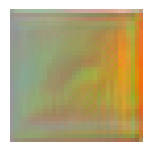

In [21]:
# For progress tracking
from tqdm.auto import trange

def predict(model, verbose=False, show_img=False):
    """
    Makes a prediction from the model based on a random pixelated image.

    Inputs:
      model, a Model object to perform the prediction on
      verbose, a boolean indicating whether debugging output should be printed
      show_img, a boolean indicating whether the predicted image should be displayed

    Returns:
      a four dimensional PyTorch tensor representing the predicted image
      after the reverse diffusion process.
    """
    # Produce 32 images with random pixelated values.
    rand_images = torch.stack([convert_rgb_to_greyscale(standardize_image(np.random.randn(model.img_size - 4, model.img_size - 4), verbose=verbose), verbose=verbose) for _ in range(32)]).float()
    if verbose:
      print(f'rand_images.shape: {rand_images.shape}')
    x = rand_images.to(device)
    # print(f'predict: x: {x}')
    # Denoise the input images by following the reverse diffusion process for each timestep.
    with torch.no_grad():
      if verbose:
        for i in trange(model.timesteps):
            t = i
            x = model(x, torch.full([32, 1], t, dtype=torch.float, device=device))
      else:
        for i in range(model.timesteps):
            t = i
            x = model(x, torch.full([32, 1], t, dtype=torch.float, device=device))

    if show_img:
      show_examples(x.cpu())
    # Return the denoised image.
    return x

predict(Model([], [], timesteps, IMG_SIZE, LEARNING_RATE).to(device), verbose=verbose, show_img=True).shape

  0%|          | 0/8 [00:00<?, ?it/s]

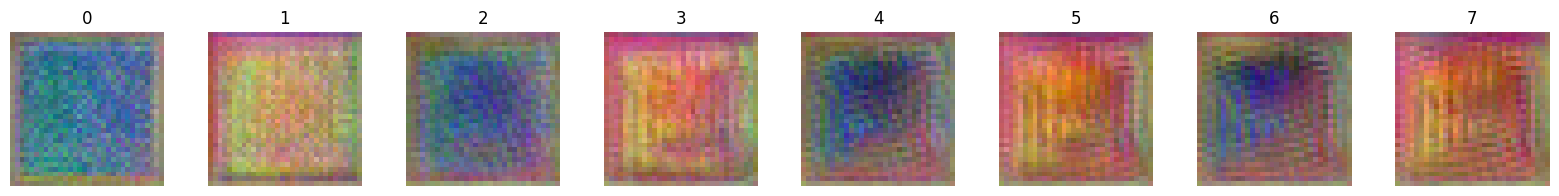

In [22]:
def predict_step(model, verbose=False):
    """
    Performs predictions while also storing and displaying the denoised image
    at the end of each timestep.

    Inputs:
      model, a Model object to perform the prediction on
      verbose, a boolean indicating whether debugging output should be printed

    Returns:
      nothing (plots the progression of the denoised image at each
      timestep through the reverse diffusion process)
    """
    # Generate 8 random images, as well as a list of images representing the
    # denoised image after each timestep.
    xs = []
    rand_images = torch.stack([convert_rgb_to_greyscale(standardize_image(np.random.randn(model.img_size - 4, model.img_size - 4), verbose=verbose), verbose=verbose) for _ in range(8)]).float()
    x = rand_images.to(device)

    # Denoise the image after each timestep, adding the denoised image to a list.
    with torch.no_grad():
        for i in trange(model.timesteps):
            t = i
            x = model(x, torch.full([8, 1], t, dtype=torch.float, device=device))
            xs.append(x[0].cpu())
    # Convert the denoised images for viewing.
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = cvtImg(xs)

    # Plot the denoised images.
    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')

predict_step(Model([], [], timesteps, IMG_SIZE, LEARNING_RATE).to(device), verbose=verbose)

In [23]:
def train_one(model, x_img, opt=None, lr_scheduler=None):
    """
    Trains the model on one input image.

    Inputs:
      model, a Model object to train and update the parameters for
      x_img, a four dimensional tensor representing one image input to the model
      opt, an optional Optimizer argument to use for training the model (otherwise, assumed
      to be a part of the model)
      lr_scheduler, an optional LearningRateScheduler argument to use for training the model
      (otherwise, assumed to be a part of the model)

    Returns:
      a float representing the loss after training the model on the input image
    """
    # Generate a random timestep, as well as the image and the noisy image at the next timestep.
    x_ts = generate_ts(len(x_img), model.timesteps)
    x_a, x_b = forward_noise(x_img, x_ts, model.data_list, model.img_size)

    # Fit these inputs to the device.
    x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
    x_a = x_a.float().to(device)
    x_b = x_b.float().to(device)

    # Predict the resulting image, and backpropogate to minimize the loss at this timestep.
    y_p = model(x_a, x_ts)
    loss = torch.mean(torch.abs(y_p - x_b))
    if opt == None:
      model.opt.zero_grad()
    else:
      opt.zero_grad()
    loss.backward()
    if opt == None:
      model.opt.step()
    else:
      opt.step()
    if lr_scheduler != None:
      lr_scheduler.step()

    # Return the loss.
    return loss.item()

In [24]:
import matplotlib.pyplot as plt
def plot_loss(loss_vals, loss_label='Loss'):
  """
  Plots the loss values as a function of the iteration number.

  Inputs:
    loss_vals, a list of loss values to plot.
    loss_label, a string labelling the type of loss to plot.

  Outputs:
    Nothing (plots the loss values by iteration number).
  """
  plt.figure(figsize=(10, 5))
  plt.plot(loss_vals, label=loss_label)
  plt.xlabel('Iterations')
  plt.ylabel(loss_label)
  plt.title(f'{loss_label} vs. Iterations')
  plt.legend()
  plt.show()

In [25]:
def train(model, batch_size, R=50):
    """
    Train the diffusion model using R epochs.

    Inputs:
      model, a Model object to train and update the parameters for
      R, an integer representing the number of epochs used to train the model.

    Returns:
      nothing (optimizes the parameters in the model during training)
    """
    bar = trange(R)
    total = len(model.base_img_idxs)
    loss_vals = []
    # For each epoch, train on all available images.
    for i in bar:
      for idx in range(0, len(model.base_img_idxs), batch_size):
        # print(f'idx: {idx}')
        batch_idxs = []
        for actual_base_idx in range(idx, idx + batch_size):
          # print(f'actual_base_idx: {actual_base_idx}')
          batch_idxs.append(model.base_img_idxs[actual_base_idx])
        loss = train_one(model, batch_idxs)
        loss_vals.append(loss)
        pg = (idx / total) * 100
        if idx % 5 == 0:
          bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')
    plot_loss(loss_vals, 'Training Loss')
    return loss_vals

# Hyperparameter Optimization

In [26]:
# Install packages for FID calculation for validation loss (hyperparameter tuning)
%pip install pytorch-fid scipy==1.11.1

# For concurrent hyperparameter optimization
%pip install ray[tune]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 47.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-ma

In [27]:
# See the number of resources available on the system

import multiprocessing

num_cpus = multiprocessing.cpu_count()
print(f"Number of CPUs: {num_cpus}")

import torch

num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")
if num_gpus > 0:
    for i in range(num_gpus):
        print(torch.cuda.get_device_name(i))

Number of CPUs: 8
Number of GPUs: 1
Tesla T4


In [28]:
import os
from PIL import Image
import numpy as np

def save_images(images, directory):
    """
    Saves an array of images to the specified directory.

    Inputs:
      images, a numpy array of grayscale images to save
      directory, a string representing the directory to savee the images

    Returns:
      Nothing (saves images at directory)
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i, img in enumerate(images):
        img = Image.fromarray(np.uint8(img * 255), 'L')  # Convert to PIL Image
        img = img.resize((299, 299))  # Resize to fit InceptionV3 size requirements
        img = img.convert('RGB')  # Convert to RGB
        img.save(os.path.join(directory, f'image_{i}.png'))

In [29]:
import random
def setup_testing_folder(digit, img_path, num_qubits, load_training_data, num_images_fid, classical, verbose=False):
  """
  Saves the testing images for the specified digit to the specified file path.

  Inputs:
    digit, an integer representing the testing digit class
    img_path, a string representing the file path to save the images to
    num_qubits, an integer representing the number of qubits on the quantum hardware (for PCA reduction)
    load_training_data, a function that returns the training data in the form
      (x_train, y_train), (x_test, y_test)
    num_images_fid, an integer representing the number of
      testing images to save in the final directory
    verbose, a boolean indicating whether debugging output should be printed

  Returns:
    Nothing (saves the testing images to img_path)
  """
  # Get the indices of the images used for the training data
  _, base_img_idxs = get_training_data(digit, img_path, load_training_data, classical, verbose)

  rand_indices = base_img_idxs
  if verbose:
    print(f'rand_indices: {rand_indices}')
  if len(rand_indices) != 500:
    print(f'len(rand_indices) is not 500, but should be: {len(rand_indices)}')

  num_pca_components = num_qubits

  (x_train, y_train), (x_test, y_test) = load_training_data()

  # print("loaded mnist data")

  x_train_flat = x_train.reshape(-1, 28*28) / 255.0
  x_test_flat = x_test.reshape(-1, 28*28) / 255.0

  # print(f'one x_train_flat data, scaled and normalized: {x_train_flat[0]}')

  x_train_category = x_train_flat[y_train == digit]
  x_test_category = x_test_flat[y_test == digit]

  one_x_categ = x_train_category[10] * 255
  one_x_categ = one_x_categ.reshape(28, 28)

  # print(f'one x_train_category data: {one_x_categ}')
  # plt.imshow(one_x_categ, cmap="gray")
  # plt.show()

  # Reshape dimension for each image, assuming the images are 28x28
  image_shape = (28, 28)

  # Store the testing images in a folder
  testing_list = []

  # Add each testing image image
  for i in range(len(x_test_category)):
      # Reshape the flattened image back to its original 28x28 dimensions
      image_reshaped = x_test_category[i].reshape(image_shape)
      testing_list.append(image_reshaped)

  # Add all images in the training dataset that were not used for training the diffusion model
  for i in range(len(x_train_category)):
    if i not in rand_indices:
      train_image_reshaped = x_train_category[i].reshape(image_shape)

      testing_list.append(train_image_reshaped)

  # Save num_images_fid images from the testing dataset
  testing_list = testing_list[len(testing_list) - num_images_fid:]
  save_images(testing_list, 'test_img' + str(digit))


In [30]:
def get_generated_images(model, img_size, num_image_batches=158, verbose=False):
  """
  Generate num_image_batches * 32 number of images from the specified model.

  Inputs:
    model, a Model object to obtain generated images from
    img_size, an integer representing the length and width of the image
    num_image_batches, an integer representing the number of batches to generate
    verbose, a boolean indicating whether or not to print debugging output

  Outputs:
    numpy_gen_imgs, a numpy array of shape (num_image_batches * 32, img_size, img_size)
    containing the generated images.
  """
  # Generate num_image_batches batches of images (where each batch contains 32 images).
  generated_images = []
  for _ in range(num_image_batches):
    generated_images.append(predict(model=model, verbose=verbose, show_img=False))
  # Randomly shuffle the generated images.
  np.random.shuffle(generated_images)
  # print('loaded', len(generated_images))

  # Convert the generated images to a numpy array, and save them at a specified directory.
  # print(generated_images[0].shape)
  generated_images_tensor = torch.cat(generated_images, axis=0)
  # print(generated_images_tensor.shape)
  permuted_gen_tensor = torch.permute(generated_images_tensor, (0, 2, 3, 1))
  # print(permuted_gen_tensor.shape)
  numpy_gen_imgs = permuted_gen_tensor.cpu().numpy()
  # print(numpy_gen_imgs.shape)
  # print(type(numpy_gen_imgs))

  return numpy_gen_imgs

In [31]:
import math

def calc_validation_loss(model, digit, img_size, img_path, num_qubits, load_training_data, validation_loss_func, num_images_fid, classical, verbose=False):
  """
  Calculates the validation loss for the input model.

  Inputs:
    model, the model for which to calculate the validation loss for
    digit, an integer representing the testing digit class
    img_size, an integer representing the length and with of the input images
    img_path, a string representing the file path to save the images to
    num_qubits, an integer representing the number of qubits on the quantum hardware (for PCA reduction)
    load_training_data, a function that returns the training data in the form
      (x_train, y_train), (x_test, y_test)
    validation_loss_func, the function to use to calculate the validation loss
    num_images_fid, an integer representing the number of
      testing images to save in the final directory
    verbose, a boolean indicating whether debugging output should be printed

  Outputs:
    a float representing the validation loss value (the FID score) for the model.
  """
  # Set up the folder containing the testing data.
  setup_testing_folder(digit, img_path, num_qubits, load_training_data, num_images_fid, classical, verbose=verbose)

  # The number of images needed for FID calculuation for the specified size.
  num_image_batches = int(math.ceil(num_images_fid / 32))

  # Save the generated images for the model.
  actual_npy_arr = get_generated_images(model, img_size, num_image_batches=num_image_batches, verbose=verbose)
  actual_imgs_list = [actual_npy_arr[i] for i in range(actual_npy_arr.shape[0])]
  reshaped_actual_imgs = []
  for actual_img in actual_imgs_list:
    grayscale_img = actual_img[2:-2, 2:-2, 0]

    # print(grayscale_img.shape)
    reshaped_actual_imgs.append(grayscale_img)
  reshaped_actual_imgs = reshaped_actual_imgs[len(reshaped_actual_imgs) - num_images_fid:]
  save_images(reshaped_actual_imgs, 'gen_img' + str(digit))

  # Paths to the directories containing the two image sets
  path1 = 'gen_img' + str(digit)
  path2 = 'test_img' + str(digit)

  # Calculate FID score
  fid_value = validation_loss_func([path1, path2], batch_size=50, device='cuda', dims=2048)
  if verbose:
    print(f'Digit {digit} FID score, Quantum:', fid_value)

  return fid_value

In [32]:
def get_global_vars():
  """
  Get the configuration variables for the model.

  Inputs:
    None

  Outputs:
    The configuration variables for the model.
  """
  return timesteps, IMG_SIZE, DIGIT, IMG_PATH, NUM_QUBITS

In [33]:
from ray import tune, train

def train_diffusion_model(config, load_training_data, validation_loss_func, num_images_fid, get_global_vars, classical, checkpoint_dir=None, val_interval=500, verbose=False):
    """
    Train a diffusion model interfacing with ray tune.

    Inputs:
      config, a dictionary providing the configuration variables for the run for this training
      load_training_data, a function that returns the training data in the form
        (x_train, y_train), (x_test, y_test)
      validation_loss_func, the function to use to calculate the validation loss
      checkpoint_dir, an optional string to indicate the directory to store the checkpoint results
      val_interval, an integer indicating the interval of epochs for which to calculate validation loss
      verbose, a boolean indicating whether debugging output should be printed

    Outputs:
      Nothing (updates ray tune with the validation loss for this run)
    """
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    # TODO: add timesteps

    timesteps, img_size, digit, img_path, num_qubits = get_global_vars()

    data_list, base_img_idxs = get_training_data(digit, img_path, load_training_data, classical, verbose)

    model = Model(data_list, base_img_idxs, timesteps, img_size, config["lr"]).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    # criterion = nn.CrossEntropyLoss()  # Update based on your loss function
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config["lr_step_size"], gamma=config["lr_gamma"])

    if checkpoint_dir:
        path = os.path.join(checkpoint_dir, "checkpoint")
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        lr_scheduler.load_state_dict(checkpoint["scheduler_state"])


    bar = range(int(config['num_epochs']))
    total = len(base_img_idxs)
    # loss_vals = []
    # For each epoch, train on all available images.
    cur_batch_size = int(config['batch_size'])
    # cur_timesteps = int(config['timesteps'])
    for i in bar:
      for idx in range(0, len(base_img_idxs), cur_batch_size):
        # print(f'idx: {idx}')
        batch_idxs = []
        for actual_base_idx in range(idx, min(len(base_img_idxs), idx + cur_batch_size)):
          # print(f'actual_base_idx: {actual_base_idx}')
          batch_idxs.append(base_img_idxs[actual_base_idx])
        loss = train_one(model, batch_idxs, opt=optimizer, lr_scheduler=lr_scheduler)
        # loss_vals.append(loss)
        # pg = (idx / total) * 100
        # if idx % 5 == 0:
        #   bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')
      if (i + 1) % val_interval == 0:
        validation_loss = calc_validation_loss(model, digit, img_size, img_path, num_qubits, load_training_data, validation_loss_func, num_images_fid, classical, verbose)
        train.report(dict(loss=validation_loss))

In [34]:
def get_save_filepath():
  """
  Obtains the filepath to store the resulting data.

  Inputs:
    None

  Returns:
    a string containing the path to the directory to save the results
  """
  return DEST_DIR_PATH

In [35]:
import multiprocessing
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter
from functools import partial
import json

def hyperparameter_tuning(config, load_training_data, validation_loss_func, num_images_fid, get_global_vars, get_save_filepath, classical, num_samples=10, max_num_epochs=2000, num_parallel_trials=4, verbose=True):
    """
    Performs hyperparameter tuning via random search for the diffusion model.

    Inputs:
      config, a configuration dictionary indicating the search space for the hyperparameters.
      load_training_data, a function that returns the training data in the form
        (x_train, y_train), (x_test, y_test)
      validation_loss_func, the function to use to calculate the validation loss
      get_global_vars, a function returning the variables used for configuring the model
      num_samples, an integer representing the number of runs to do for hyperparameter tuning
      max_num_epochs, an integer representing the maximum number of epochs for any one run
      num_parallel_trials, an integer representing the number of parallel trials to run
      verbose, a boolean indicating whether debugging output should be printed

    Outputs:
      None (saves the results of hyperparameter tuning to a file)
    """
    # Define a scheduler to decide how to schedule each trial on the hardware
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=500,
        reduction_factor=2)

    # Displays the results of hyperparameter tuning.
    reporter = CLIReporter(metric_columns=["loss", "training_iteration"])

    # Define the function for which the trial of training the diffusion model should be in.
    train_diffusion_model_args = partial(train_diffusion_model, load_training_data=load_training_data, validation_loss_func=validation_loss_func, num_images_fid=num_images_fid, get_global_vars=get_global_vars, classical=classical)

    result = tune.run(
        train_diffusion_model_args,
        resources_per_trial={"cpu": (multiprocessing.cpu_count() / num_parallel_trials), "gpu": (torch.cuda.device_count() / num_parallel_trials)},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter
    )

    # Save the best trial
    best_trial = result.get_best_trial("loss", "min", "last")
    if verbose:
      print(f"Best trial config: {best_trial.config}")
      print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    # Assuming best_trial is obtained as shown before
    best_config = best_trial.config
    best_loss = best_trial.last_result['loss']

    # Prepare a dictionary to save
    save_dict = {
        "best_config": best_config,
        "best_loss": best_loss
    }

    save_filepath = get_save_filepath()

    # Choose a file path
    file_path = f"{save_filepath}/best_trial_config.json"

    # Write to a JSON file
    with open(file_path, "w") as f:
        json.dump(save_dict, f, indent=4)

In [36]:
print(os.cpu_count())
print(multiprocessing.cpu_count())

8
8


In [ ]:
from pytorch_fid.fid_score import calculate_fid_given_paths

# Define the search space for the hyperparameters.
config = {
    "batch_size": tune.choice([2, 4, 8, 16, 32]),
    # "timesteps": tune.choice([2, 4, 6, 8]),
    "lr": tune.loguniform(1e-5, 1e-1),
    "lr_step_size": tune.choice([50, 100, 200]),
    "lr_gamma": tune.choice([0.1, 0.5, 0.9]),
    "num_epochs": tune.choice([500, 1000, 1500, 2000])
}

# Define the number of images to use for FID calculation.
num_images_fid = 5000

hyperparameter_tuning(config, tf.keras.datasets.mnist.load_data, calculate_fid_given_paths, num_images_fid, get_global_vars, get_save_filepath, CLASSICAL, num_samples=20, max_num_epochs=2000, num_parallel_trials=4)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-10 00:19:11,091	INFO worker.py:1753 -- Started a local Ray instance.
2024-06-10 00:19:11,930	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-06-10 00:19:12,097	WARNING tune.py:902 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+------------------------------------------------------------------------------+
| Configuration for experiment     train_diffusion_model_2024-06-10_00-19-11   |
+------------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                       |
| Scheduler                        AsyncHyperBandScheduler                     |
| Number of trials                 20                                          |
+------------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_diffusion_model_2024-06-10_00-19-11
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-10_00-19-08_924375_1449/artifacts/2024-06-10_00-19-11/train_diffusion_model_2024-06-10_00-19-11/driver_artifacts`

Trial status: 20 PENDING
Current time: 2024-06-10 00:19:12. Total running time: 0s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.

(pid=3233) 2024-06-10 00:19:17.343814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3233) 2024-06-10 00:19:17.343873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=3233) 2024-06-10 00:19:17.345543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=3236) 2024-06-10 00:19:18.890852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial train_diffusion_model_0ff20_00003 started with configuration:
+------------------------------------------------------------+
| Trial train_diffusion_model_0ff20_00003 config             |
+------------------------------------------------------------+
| batch_size                                              32 |
| lr                                                 0.00209 |
| lr_gamma                                               0.5 |
| lr_step_size                                            50 |
| num_epochs                                            1500 |
+------------------------------------------------------------+
(func pid=3236) Downloading data from https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
11490434/11490434 [==============================] - 0s 0us/step

Trial train_diffusion_model_0ff20_00002 started with configuration:
+----------------------------------------------------------+
| Trial train_diffusion_model_0ff20_00002 config           |


# Model Training (Given Hyperparameters)

In [ ]:
def get_classical():
  """
  Returns whether or not to train a diffusion model with classical noise.

  Inputs:
    None

  Returns:
    a boolean indicating whether or not to train with classical noise.
  """
  return CLASSICAL

In [ ]:
def get_hyperparameters():
  """
  Obtains the hyperparameters for training one specific instance of model.

  Inputs:
    None

  Returns:
    The hyperparameters for training one instance of model.
  """
  return TRAINING_ITERS, NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE

In [ ]:
def construct_model(get_global_vars, get_hyperparameters, get_training_data, load_training_data, classical, verbose=False):
    """
    Constructs a model object for training.

    Inputs:
      get_global_vars, a function that returns configuration variables for the model
      get_training_data, a function that returns the training data for the model

    Outputs:
      a Model object with configuration specified by get_global_vars and training data from get_training_data
    """
    timesteps, img_size, digit, img_path, num_qubits = get_global_vars()

    training_iters, num_epochs, batch_size, learning_rate = get_hyperparameters()

    data_list, base_img_idxs = get_training_data(digit, img_path, load_training_data, classical, verbose)

    model = Model(data_list, base_img_idxs, timesteps, img_size, learning_rate).to(device)

    return model

In [ ]:
def train_model_hyperparams(model, get_global_vars, get_hyperparameters, load_training_data, validation_loss_func, num_images_fid, classical, verbose=False):
  """
  Trains a model for a specific set of hyperparameters (decoupled from Ray Tune reporting).

  Inputs:
    model, the model for which to calculate the validation loss for
    get_global_vars, a function returning the variables used for configuring the model
    get_hyperparameters, a function returning the hyperparameters for this particular run
    load_training_data, a function that returns the training data in the form
      (x_train, y_train), (x_test, y_test)
    validation_loss_func, the function to use to calculate the validation loss
    num_images_fid, an integer representing the number of
      testing images to save in the final directory
    verbose, a boolean indicating whether debugging output should be printed

  Outputs:
    The same model object, with weights updated
  """
  timesteps, img_size, digit, img_path, num_qubits = get_global_vars()

  training_iters, num_epochs, batch_size, learning_rate = get_hyperparameters()

  global_loss_vals = []
  global_validation_loss_vals = []
  setup_testing_folder(digit, img_path, num_qubits, load_training_data, num_images_fid, verbose=False)

  # Perform 10 training iterations, reducing the learning rate for every subsequent training.
  for _ in range(training_iters):
      loss_vals = train(model, batch_size, num_epochs)
      global_loss_vals.extend(loss_vals)
      validation_loss = calc_validation_loss(model, digit, img_path, num_qubits, load_training_data, validation_loss_func, num_images_fid, classical, verbose)
      global_validation_loss_vals.append(validation_loss)
      plot_loss(global_loss_vals, 'Training Loss')
      plot_loss(global_validation_loss_vals, 'Validation Loss')
      # Reduce learning rate for next training
      for pg in model.opt.param_groups:
          pg['lr'] = max(0.000001, pg['lr'] * 0.9)

      # Show result after each training
      predict(model, verbose)
      predict_step(model, verbose)
      plt.show()

  return model

In [ ]:
def main(save=False, verbose=False):
  """
  Trains a diffusion model given a specified set of hyperparameters.

  Inputs:
    save, a boolean indicating whether or not to save the results of this run
    verbose, a boolean indicating whether debugging output should be printed

  Outputs:
    None (prints results to the console with verbosity indicated by verbose,
    and saves the results if save is True)
  """
  timesteps, img_size, digit, img_path, num_qubits = get_global_vars()

  num_images_fid = 5000
  classical = get_classical()
  model = construct_model(get_global_vars, get_hyperparameters, get_training_data, tf.keras.datasets.mnist.load_data, classical, verbose)
  train_model_hyperparams(model, get_global_vars, get_hyperparameters, tf.keras.datasets.mnist.load_data, calculate_fid_given_paths, num_images_fid, classical, verbose)

  num_image_batches = 158

  generated_imgs = get_generated_images(model, img_size, num_image_batches, verbose)

  save_filepath = get_save_filepath()

  if save:
    training_iters, num_epochs, batch_size, learning_rate = get_hyperparameters()
    np.save(save_filepath + "/generated_imgs_" + str(digit) + "_batch_size_" + str(batch_size) + "_learning_rate_" + str(learning_rate) + "_timesteps_" + str(timesteps) + "_normnoise_" + "training_iters_" + str(training_iters) + "_num_epochs_" + str(num_epochs) + "_num_images_" + str(num_image_batches * 32) + ".npy", generated_imgs)
    torch.save(model.state_dict(), save_filepath + "/generated_imgs_" + str(digit) + "_batch_size_" + str(batch_size) + "_learning_rate_" + str(learning_rate) + "_timesteps_" + str(timesteps) + "_normnoise_" + "training_iters_" + str(training_iters) + "_num_epochs_" + str(num_epochs) + ".pth")
    print(f"Saved generated images and model weights.")

In [ ]:
# Train the diffusion model, given a specific set of hyperparameters.
main(save=False, verbose=verbose)